#### Implement the baseline algos here

In [1]:
import sys; sys.path.insert(0, "../"); from utils import *
import pickle

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from pde_diff import *
import robust_PDE_FIND
from robust_PDE_FIND import TrainSTRidge, compute_err, print_pde, RobustPCA, Robust_LRSTR
import scipy.io as sio

Running Python 3.9.7
You can use npar for np.array
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['diff', 'save']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [14]:
# Loading the KS sol
# data = sio.loadmat("../R_DLGA_datasets/KS.mat")
# data = sio.loadmat("../deephpms_data/KS.mat")

# t = data['t'][0]; time_dims = t.shape[0]
# x = data['x'][0]; spatial_dims = x.shape[0]
# total_points = time_dims*spatial_dims
# print("Total data points:", total_points)

# X, T = np.meshgrid(x, t)
# Exact = data['usol']
# u = Exact

import numpy as np
from rkstiff import grids
from rkstiff import if34

# Computing the KS sol
# uniform grid spacing, real-valued u -> construct_x_kx_rfft
N = 256
a, b = 0, 16*np.pi
x, kx = grids.construct_x_kx_rfft(N, a, b)

L = kx**2*(1-kx**2)
def NL(uFFT):
    u = np.fft.irfft(uFFT)
    ux = np.fft.irfft(1j*kx*uFFT)
    return -np.fft.rfft(u*ux)

u0 = -np.sin(np.pi*x/10)
# u0 = np.cos(x/16)*(1.+np.sin(x/16))
u0FFT = np.fft.rfft(u0)
solver = if34.IF34(linop=L,NLfunc=NL)
ufFFT = solver.evolve(u0FFT, t0=0, tf=8) # store every 20th step in solver.u and solver.t

U = []
for uFFT in solver.u:
    U.append(np.fft.irfft(uFFT))
U = np.array(U)
t = np.array(solver.t)

X, T = np.meshgrid(x, t)
Exact = U.T
u = Exact

<ipython-input-15-92c3c6bcfb44>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig1.gca(projection='3d')


Text(0.5, 0, 't')

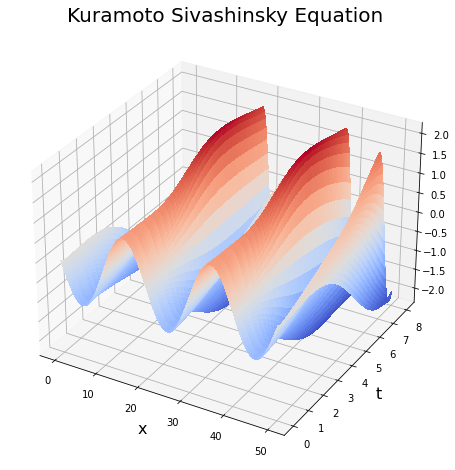

In [15]:
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Kuramoto Sivashinsky Equation', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

#### STR

In [16]:
dt = t[1]-t[0]
dx = x[2]-x[1]
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=5, P=5, time_diff = 'FD', space_diff = 'FD')

In [17]:
w = TrainSTRidge(R,Ut,10**-5,50)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-0.997619 +0.000000i)uu_{x}
    + (-1.048322 +0.000000i)u_{xx}
    + (-1.055897 +0.000000i)u_{xxxx}
   


In [19]:
U.shape

(89, 256)

In [20]:
with open("../deephpms_data/KS_new.pkl", "wb") as f:
    pickle.dump(dict({'x':x, 't':t, 'u':U}), f)

In [9]:
errs = 100*(np.abs(npar([-0.997619, -1.048322, -1.055897])+1))
errs.mean(), errs.std()

(3.5533333333333346, 2.364533865738074)

#### STR + noise

In [8]:
noise_intensity = 1e-4
numpy.random.seed(0)
un = u + noise_intensity*std(u)*np.random.randn(u.shape[0],u.shape[1])

In [9]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=5, P=5, 
                                 time_diff = 'poly', space_diff = 'poly', 
                                 width_x = 20, width_t = 20, deg_x = 6)

print(Utn.shape[0] == total_points)

# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,50)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

False
PDE derived using STRidge
u_t = (-0.898714 +0.000000i)uu_{x}
    + (-0.892278 +0.000000i)u_{xx}
    + (-0.894271 +0.000000i)u_{xxxx}
   


In [26]:
errs = 100*(npar([-0.898714, -0.892278, -0.894271])+1)
errs.mean(), errs.std()

(10.491233333333332, 0.269019606885611)

#### DLrSR

In [10]:
u_in = u

Z, E1 = RobustPCA(u_in, lam_2 = 0.1)

ZUtn, ZRn, rhs_des = build_linear_system(Z, dt, dx, D=5, P=5, 
                                 time_diff = 'poly', space_diff = 'poly', 
                                 width_x = 20, width_t = 20, deg_x = 6)

iteration:1, err:4960.584396627079, nc_norm:1355.7461711239587 eta1:0.003493309115417748
iteration:50, err:0.1989168013632654, nc_norm:1493.6299284319684 eta1:0.372802305846641
iteration:100, err:0.0017653071524626356, nc_norm:759.4992935910963 eta1:43.76358063885437
iteration:150, err:1.8577246612711326e-05, nc_norm:753.246036154266 eta1:5137.444056264458
iteration:157, err:9.476470069374354e-06, nc_norm:753.2198834125609 eta1:10011.425082735917


In [11]:
double_width = 0
for n in range(0, 101):
    if ZUtn.shape[0] == (spatial_dims-n)*(time_dims-n):
        double_width = n
        nx = spatial_dims-n
        nt = time_dims-n
        print(double_width); break

40


In [12]:
# Solve with DLrSR
Utn1 = np.reshape(ZUtn, (nx,nt))
w, X, E2=Robust_LRSTR(ZRn, Utn1, rhs_des, lam_1 = 1e-5, lam_3 = 0.15, lam_4 = 1, d_tol = 1)
print_pde(w, rhs_des)

iteration:1, err:1024.5967465183605, nc_norm:475.64140865115075 eta2:0.01681288981377874
u_t = 
u_t = (-0.297678 +0.000000i)uu_{x}
    + (-0.299221 +0.000000i)u_{xx}
    + (-0.299206 +0.000000i)u_{xxxx}
   
u_t = (-0.723483 +0.000000i)uu_{x}
    + (-0.727232 +0.000000i)u_{xx}
    + (-0.727196 +0.000000i)u_{xxxx}
   
u_t = (-1.076014 +0.000000i)uu_{x}
    + (-1.081567 +0.000000i)u_{xx}
    + (-1.081521 +0.000000i)u_{xxxx}
   
u_t = (-1.225359 +0.000000i)uu_{x}
    + (-1.231671 +0.000000i)u_{xx}
    + (-1.231628 +0.000000i)u_{xxxx}
   
u_t = (-1.176481 +0.000000i)uu_{x}
    + (-1.182555 +0.000000i)u_{xx}
    + (-1.182522 +0.000000i)u_{xxxx}
   
u_t = (-1.040912 +0.000000i)uu_{x}
    + (-1.046326 +0.000000i)u_{xx}
    + (-1.046296 +0.000000i)u_{xxxx}
   
u_t = (-0.938408 +0.000000i)uu_{x}
    + (-0.943333 +0.000000i)u_{xx}
    + (-0.943298 +0.000000i)u_{xxxx}
   
u_t = (-0.914257 +0.000000i)uu_{x}
    + (-0.919087 +0.000000i)u_{xx}
    + (-0.919044 +0.000000i)u_{xxxx}
   
u_t = (-0.938110

In [27]:
errs = np.abs(100*(npar([-0.963024, -0.968161, -0.968131])+1))
errs.mean(), errs.std()

(3.3561333333333327, 0.2414565017186793)

#### DLrSR + noise (Normal distributed noise)

In [14]:
u_in = un

Z, E1 = RobustPCA(u_in, lam_2 = 0.1)

ZUtn, ZRn, rhs_des = build_linear_system(Z, dt, dx, D=5, P=5, 
                                 time_diff = 'poly', space_diff = 'poly', 
                                 width_x = 20, width_t = 20, deg_x = 6)

iteration:1, err:4960.5567904265135, nc_norm:1356.7292883508576 eta1:0.003493309024576845
iteration:50, err:0.13332996457977506, nc_norm:1494.1120077295477 eta1:0.3728022961521946
iteration:100, err:0.010875083745640819, nc_norm:760.0154162429593 eta1:43.76357950081503
iteration:130, err:7.37804921559075e-06, nc_norm:754.0823611203639 eta1:763.6483034361141


In [15]:
# Solve with DLrSR
Utn1 = np.reshape(ZUtn, (nx,nt))
w, X, E2=Robust_LRSTR(ZRn, Utn1, rhs_des, lam_1 = 1e-5, lam_3 = 0.15, lam_4 = 1, d_tol = 1)
print_pde(w, rhs_des)

iteration:1, err:1024.5963542955055, nc_norm:475.64169538413074 eta2:0.016812897002534657
u_t = 
u_t = (-0.277265 +0.000000i)uu_{x}
    + (-0.275340 +0.000000i)u_{xx}
    + (-0.276066 +0.000000i)u_{xxxx}
   
u_t = (-0.667535 +0.000000i)uu_{x}
    + (-0.661936 +0.000000i)u_{xx}
    + (-0.663927 +0.000000i)u_{xxxx}
   
u_t = (-0.991168 +0.000000i)uu_{x}
    + (-0.982631 +0.000000i)u_{xx}
    + (-0.985666 +0.000000i)u_{xxxx}
   
u_t = (0.004019 +0.000000i)u^5
    + (-1.137704 +0.000000i)uu_{x}
    + (-1.107860 +0.000000i)u_{xx}
    + (-0.028694 +0.000000i)u^2u_{xx}
    + (0.022572 +0.000000i)u^4u_{xx}
    + (-0.003016 +0.000000i)u^5u_{xxx}
    + (-1.134078 +0.000000i)u_{xxxx}
    + (0.007333 +0.000000i)u^4u_{xxxx}
   
u_t = (0.006177 +0.000000i)u^5
    + (-1.100858 +0.000000i)uu_{x}
    + (-1.060789 +0.000000i)u_{xx}
    + (-0.043384 +0.000000i)u^2u_{xx}
    + (0.034292 +0.000000i)u^4u_{xx}
    + (-0.004573 +0.000000i)u^5u_{xxx}
    + (-1.098958 +0.000000i)u_{xxxx}
    + (0.011139 +0.0000

In [28]:
errs = np.abs(100*(npar([-0.667535, -0.661936, -0.663927])+1))
errs.mean(), errs.std()

(33.553399999999996, 0.23173391350138545)

#### Notes on the AAAI'20 paper
    - The algo needs grid. Not possible to run the algo on freely distributed data points.
    - Assume strictly sparse-distributed noise.
    - It is not clear how to tune the lagrange multiplier hyper parameters so that the optimal true PDE is obtained.
    - The PDE solution and the pde diff features are not learned or updated joinly, hence, the sub-optimal equation is discovered, especially in the noisy case.

In [ ]:
u_t = (-0.991168 +0.000000i)uu_{x}
    + (-0.982631 +0.000000i)u_{xx}
    + (-0.985666 +0.000000i)u_{xxxx}
    
errs = np.abs(100*(npar([-0.991168, -0.982631, -0.985666])+1))
errs.mean(), errs.std()

# (1.3511666666666624, 0.3533389905207501)